In [1]:
%load_ext autoreload
%autoreload 2

# Check the suppression hypothesis

As part of the review, a good question arised about the impact suppression can have on our estimates. In this notebook we include the figures we added to the paper regarding this: 

- Fig S16: Role of fire supression in treatment effect estimates (Panel A, B, and C)

In [2]:
import re
from functools import reduce

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rapidfuzz.process import extractOne

from prescribed.estimate.calculate_estimator import calculate_estimator
from prescribed.plot import plot_outcomes, plot_std_diffs, template_plots
from prescribed.utils import prepare_template

results_dir = "../tyra/wild_treats_results_only"
criteria = "loss"

# Set the font to be serif, rather than sans
plt.rcParams["font.family"] = "Helvetica Neue"

# Set the font size to be 12
plt.rcParams["font.size"] = 18

# Make fonts compatible with illustrator
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

# Set colors for each land type and measurement
colors_land_type = {
    "conifers": "#7fc97f",
    "shrublands": "#beaed4",
    "hardwood": "#fdc086",
    "conifer-hardwood": "#386cb0",
    "other": "gray",
}

colors_land_type_int = {
    2: "#7fc97f",
    12: "#beaed4",
    8: "#fdc086",
    3: "#386cb0",
}

colors_measurement = {
    "severity": "Greens",
    "intensity": "Oranges",
}

colors_measurement_land_types = {
    "conifers": "Greens",
    "conifer-hardwood": "Oranges",
    "hardwood": "Blues",
    "shrublands": "Purples",
}

In [3]:
# Load MTBS to add years to severity and other data
mtbs = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
)
mtbs["year"] = mtbs.Ig_Date.dt.year
mtbs_ca = mtbs[(mtbs["Event_ID"].str.startswith("CA")) & (mtbs["year"] >= 2006)]


# Load template to identify wilderness areas within cell/pixels
template = (
    prepare_template(
        "/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif"
    )
    .groupby(["grid_id"], as_index=False)
    .first()
    .drop(columns=["year"])
)

# Template, but with geometry to match with blm wildernesses
template = gpd.GeoDataFrame(
    template,
    geometry=gpd.points_from_xy(x=template.lat, y=template.lon),
    crs="EPSG:3310",
)

blm = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/blm/BLM_CA_NLCS_Wilderness_Area_Polygons.shp"
).to_crs("EPSG:3310")

blm["desig_year"] = blm.DESIG_DATE.dt.year

# Merge template with blm wildernesses
blm_template = gpd.sjoin(template, blm, how="inner", predicate="within")

# Calculate area
blm["area"] = blm.area / 1e6  # in square kilometers

# Load land types to merge treatments with land type
land_type = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/land_type/land_type.feather"
)

dnbr = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/dnbr_gee/dnbr_long.feather"
).merge(land_type, on="grid_id", how="inner")

dnbr = dnbr.merge(
    mtbs_ca[["Event_ID", "year", "Incid_Name"]],
    left_on="event_id",
    right_on="Event_ID",
    how="left",
)

## Fig S16: Role of fire suppression in treatment effect estimates (Panel A)

In [4]:
from prescribed.build.build_data import classify_dnbr

dnbr = classify_dnbr(dnbr)

dnbr["wilderness"] = np.where(
    dnbr.grid_id.isin(
        blm_template[blm_template.DESIG_DATE.dt.year <= 2008].grid_id.tolist()
    ),
    1,
    0,
)

dnbr["treated"] = np.where(dnbr.class_dnbr == 2, 1, 0)

class_dnbr_wild = (
    # dnbr
    dnbr[(dnbr.land_type == 2) & (dnbr.year >= 2008)]
    .groupby(["class_dnbr", "year", "wilderness"], as_index=False)
    .size()
)

class_dnbr_wild["year"] = class_dnbr_wild["year"].astype(int)

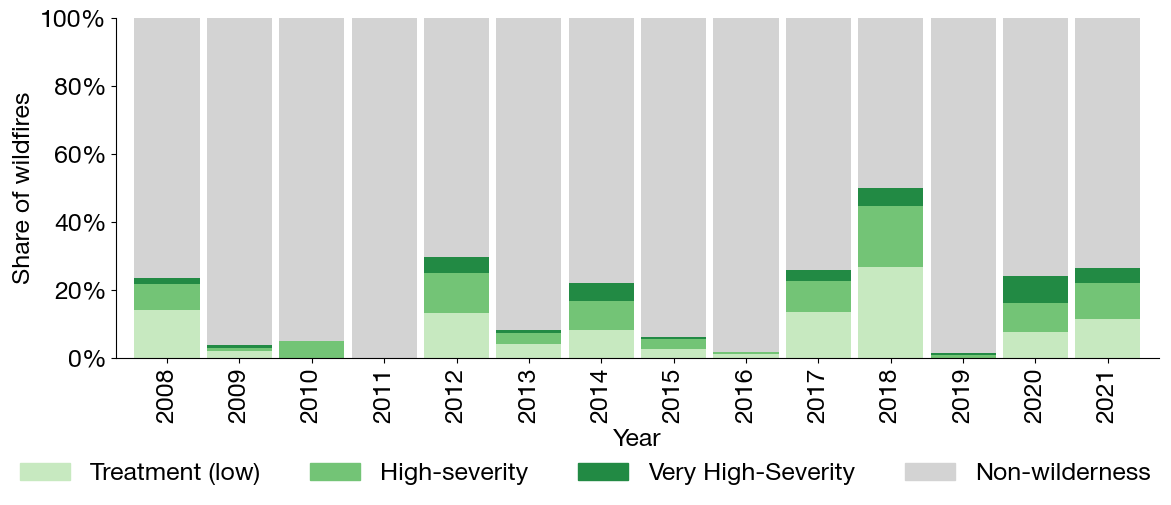

In [5]:
# Stacked shares by year:
# - Wilderness split by severity class (2,3,4)
# - Non-wilderness aggregated (gray)

from matplotlib import ticker as mticker

df = class_dnbr_wild[class_dnbr_wild["class_dnbr"] > 1].copy()
df["year"] = df["year"].astype(int)

# Counts by (year, wilderness, class)
g = (
    df.groupby(["year", "wilderness", "class_dnbr"])["size"]
    .sum()
    .unstack(["wilderness", "class_dnbr"])
    .fillna(0.0)
    .sort_index()
)

# Build plotting table:
# - Wilderness split by class 2/3/4
# - Non-wilderness aggregated across classes
classes = [2, 3, 4]
plot_counts = pd.DataFrame(index=g.index)

# Add wilderness-by-class columns (ensure present)
for c in classes:
    col = (1, c)
    plot_counts[f"Wilderness: Class {c}"] = g[col] if col in g.columns else 0.0

# Non-wilderness total
non_wild_total = g.loc[:, [(0, c) for c in classes if (0, c) in g.columns]].sum(
    axis=1
)
plot_counts["Non-wilderness"] = non_wild_total

# Convert to shares (100% stacked)
den = plot_counts.sum(axis=1).replace(0, np.nan)
shares = (plot_counts.div(den, axis=0)).fillna(0.0)

# Colors: wilderness classes with a Greens gradient, non-wild gray
wild_colors = sns.color_palette("Greens", len(classes))
class_color_map = {c: wild_colors[i] for i, c in enumerate(classes)}
colors = [class_color_map[c] for c in classes] + ["lightgray"]

# Order: Wilderness (2,3,4) then Non-wilderness to match prior figure style
shares = shares[
    [
        "Wilderness: Class 2",
        "Wilderness: Class 3",
        "Wilderness: Class 4",
        "Non-wilderness",
    ]
]

fig, ax = plt.subplots(figsize=(12, 5))
shares.plot(
    kind="bar",
    stacked=True,
    ax=ax,
    color=colors,
    width=0.9,
    legend=False,
)

ax.set_xlabel("Year")
ax.set_ylabel("Share of wildfires")
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
sns.despine()
plt.tight_layout()

# Legend
handles = [
    plt.Rectangle((0, 0), 1, 1, color=class_color_map[2]),
    plt.Rectangle((0, 0), 1, 1, color=class_color_map[3]),
    plt.Rectangle((0, 0), 1, 1, color=class_color_map[4]),
    plt.Rectangle((0, 0), 1, 1, color="lightgray"),
]
fig.legend(
    handles,
    [
        "Treatment (low)",
        "High-severity",
        "Very High-Severity",
        "Non-wilderness",
    ],
    loc="lower center",
    ncol=4,
    frameon=False,
    bbox_to_anchor=(0.5, -0.05),
    bbox_transform=fig.transFigure,
)
fig.subplots_adjust(bottom=0.25)

# Optionally save
fig.savefig(
    "../figs/wilderness_share_by_severity.pdf", dpi=300, bbox_inches="tight"
)


In [6]:
treatments = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/wide_treatments_gee/wide_treats_mtbs.feather"
)

# Remove all the treatments that have a wildland designation after 2008. This
# can potentially bias the results as these areas can be systmematically
# different
treatments_clean = treatments[
    ~treatments.grid_id.isin(
        blm_template[blm_template.desig_year >= 2008].grid_id.tolist()
    )
]

# Now let's see how many treatments we have in wildland areas
treatments_clean["wildland"] = np.select(
    [
        treatments_clean.grid_id.isin(
            blm_template[blm_template.desig_year < 2008].grid_id.tolist()
        )
    ],
    [1],
    default=0,
)

# Now, let's redefine the treatments accurately using the wildlands
treat_cols = [c for c in treatments_clean.columns if "treat_" in c]

# Sum all treatments
all_treats = treatments_clean[treat_cols].sum(axis=0)

for col in treat_cols:
    treatments_clean[col] = treatments_clean[col] * treatments_clean["wildland"]
wild_treats = treatments_clean[treat_cols].sum(axis=0)

# Crate a dataframe to compare the treatments
all_treats.index = [int(c.split("_")[-1]) for c in all_treats.index]
wild_treats.index = [int(c.split("_")[-1]) for c in wild_treats.index]

df_plot = pd.concat([all_treats, wild_treats], axis=1)
df_plot.columns = ["all_treats", "wild_treats"]
df_plot = df_plot[df_plot.index <= 2021]

/tmp/ipykernel_22642/1588855920.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treatments_clean["wildland"] = np.select(
/tmp/ipykernel_22642/1588855920.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treatments_clean[col] = treatments_clean[col] * treatments_clean["wildland"]


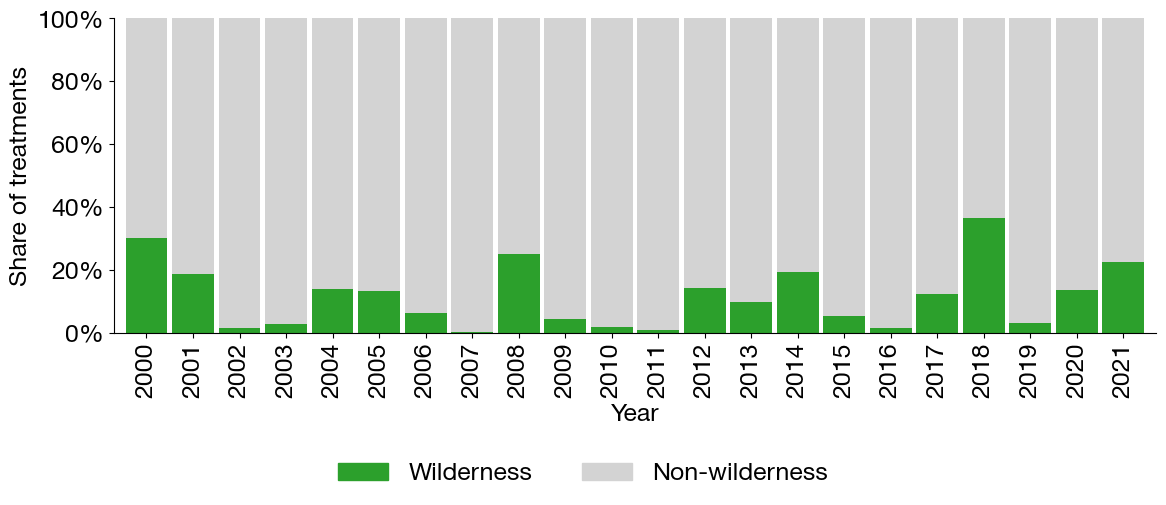

In [7]:
from matplotlib import ticker as mticker

# Prepare shares
df_prop = df_plot.copy()
df_prop.index.name = "year"
den = df_prop["all_treats"].replace(0, np.nan)
df_prop["wild_share"] = (df_prop["wild_treats"] / den).clip(0, 1).fillna(0.0)
df_prop["non_wild_share"] = (1 - df_prop["wild_share"]).clip(0, 1)

df_long = (
    df_prop[["wild_share", "non_wild_share"]]
    .reset_index()
    .melt(id_vars="year", var_name="type", value_name="share")
)

shares = df_prop[["wild_share", "non_wild_share"]].copy().sort_index()
shares.index = shares.index.astype(int)  # ensure discrete x

fig, ax = plt.subplots(figsize=(12, 5))
shares.plot(
    kind="bar",
    stacked=True,
    ax=ax,
    color=["#2ca02c", "lightgray"],
    width=0.9,
    legend=False,
)
ax.set_xlabel("Year")
ax.set_ylabel("Share of treatments")
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))


# Tighten axes layout first, then add a figure legend
plt.tight_layout()
handles = [
    plt.Rectangle((0, 0), 1, 1, color="#2ca02c"),
    plt.Rectangle((0, 0), 1, 1, color="lightgray"),
]
fig.legend(
    handles,
    ["Wilderness", "Non-wilderness"],
    loc="lower center",
    ncol=2,
    frameon=False,
    bbox_to_anchor=(0.5, -0.05),
    bbox_transform=fig.transFigure,
)
fig.subplots_adjust(bottom=0.30)  # make room
sns.despine()

# Save plot to PDF
fig.savefig(
    "../figs/wildland_treatment_shares.pdf",
    format="pdf",
    bbox_inches="tight",
    dpi=300,
)

## Figure S16: Role of fire suppression in treatment effect estimates (Panel C and D)

Notice this is reading the outcomes of the main results to plot a gray line to compare the suppression subset against the original results. The file is called `og_results.csv` and is saved from the `results_figures_replication.ipynb` notebook

In [10]:
# Load MTBS CA events to get fire years
mtbs = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
)
mtbs["year"] = mtbs.Ig_Date.dt.year
mtbs_ca = mtbs[(mtbs["Event_ID"].str.startswith("CA")) & (mtbs["year"] >= 2006)]

# Load land types to merge treatments with land type
land_type = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/land_type/land_type.feather"
)

# Load all treatments
wide_treatments = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/wide_treatments_gee/wide_treats_mtbs_wildlands.feather"
).merge(land_type, on="grid_id", how="left")

conifers_loss = {
    "weights_dnbr": pd.read_csv(
        f"{results_dir}/dnbr_treatment_conifers/best_model_{criteria}_weights.csv"
    ),
    "std_diffs_dnbr": pd.read_csv(
        f"{results_dir}/dnbr_treatment_conifers/best_model_{criteria}_std_diffs.csv"
    ),
}

# Load dnbr to get years
dnbr = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/dnbr_gee/dnbr_long.feather"
)

dnbr = dnbr.merge(
    mtbs_ca[["Event_ID", "year"]],
    left_on="event_id",
    right_on="Event_ID",
    how="left",
)

og_rrs = pd.read_csv("../data/results/results_pooled.csv")

In [14]:

# Calculate no pool and pool results using the ATT estimator
treat_df = wide_treatments

atts = calculate_estimator(
    treatments=treat_df[(treat_df.land_type == 2) & (treat_df.wildland == 1)],
    weights=conifers_loss["weights_dnbr"],
    outcomes=dnbr,
    focal_years=range(2008, 2021),
    outcome_var="dnbr",
    low_treatment_class={"dnbr": 1},
    pooling=True,
    cluster_var="year",
    formula="att ~ lag",
    weight_var="att_se",
    max_lags=12,
    rr=False,
)
atts_no_pool = calculate_estimator(
    treatments=treat_df[(treat_df.land_type == 2) & (treat_df.wildland == 1)],
    weights=conifers_loss["weights_dnbr"],
    outcomes=dnbr,
    focal_years=range(2008, 2021),
    outcome_var="dnbr",
    low_treatment_class={"dnbr": 1},
    pooling=False,
    cluster_var="year",
    formula="att ~ lag",
    weight_var="att_se",
    max_lags=12,
    rr=False,
)

Calculating estimator per focal year...:   0%|          | 0/13 [00:00<?, ?it/s]

Error calculating estimator for focal year 2010: cannot insert year, already exists
Error calculating estimator for focal year 2011: cannot insert year, already exists
Calculating estimator per focal year...:  46%|████▌     | 6/13 [00:00<00:00, 58.49it/s]Error calculating estimator for focal year 2019: cannot insert year, already exists


Processing focal year: 2008
Processing focal year: 2009
Processing focal year: 2010
No weighted outcomes available.
Processing focal year: 2011
No weighted outcomes available.
Processing focal year: 2012
Processing focal year: 2013
Processing focal year: 2014
Processing focal year: 2015
Processing focal year: 2016
Processing focal year: 2017
Processing focal year: 2018
Processing focal year: 2019
No weighted outcomes available.
Processing focal year: 2020


Calculating estimator per focal year...:   0%|          | 0/13 [00:00<?, ?it/s]Error calculating estimator for focal year 2010: cannot insert year, already exists
Error calculating estimator for focal year 2011: cannot insert year, already exists
Calculating estimator per focal year...:  54%|█████▍    | 7/13 [00:00<00:00, 63.13it/s]Error calculating estimator for focal year 2019: cannot insert year, already exists


Processing focal year: 2008
Processing focal year: 2009
Processing focal year: 2010
No weighted outcomes available.
Processing focal year: 2011
No weighted outcomes available.
Processing focal year: 2012
Processing focal year: 2013
Processing focal year: 2014
Processing focal year: 2015
Processing focal year: 2016
Processing focal year: 2017
Processing focal year: 2018
Processing focal year: 2019
No weighted outcomes available.
Processing focal year: 2020


Calculating estimator per focal year...: 100%|██████████| 13/13 [00:00<00:00, 61.80it/s]


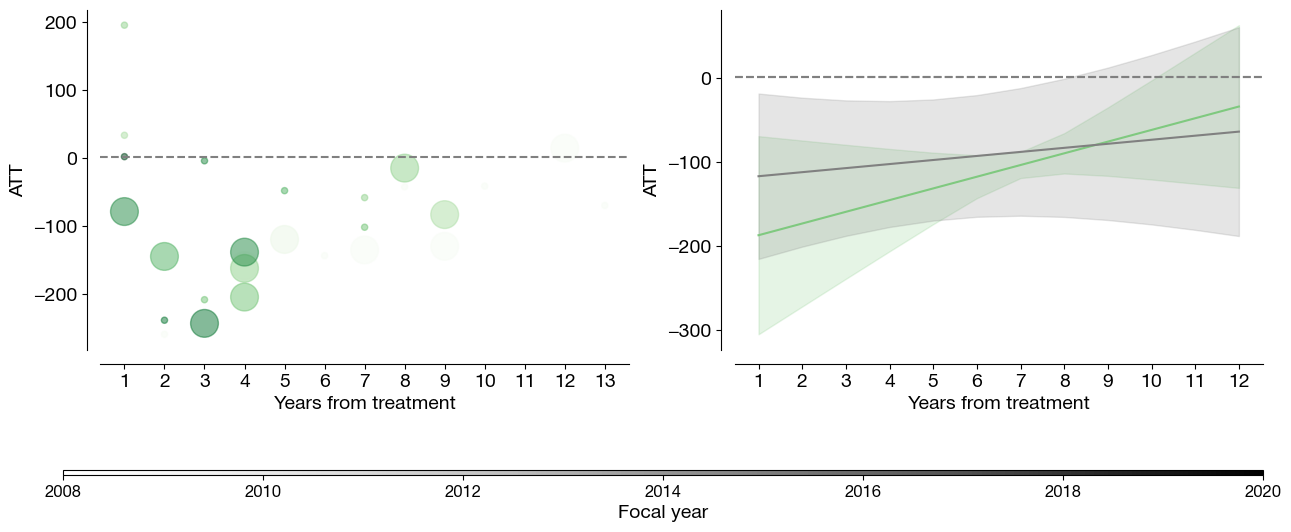

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

plot_outcomes(
    dfs=[atts_no_pool[atts_no_pool.lag > 0]],
    labels=["Conifers"],
    legend=False,
    axes_names=(
        "Years from treatment",
        r"ATT",
    ),
    ax=ax[0],
    cmaps=[
        "Greens",
    ],
    colors=[
        colors_land_type["conifers"],
    ],
    pooled=False,
    axis_text=14,
    label_axis=14,
    dotted=1,
    label_pos=(-0.1, 1.1),
    size=20,
)

plot_outcomes(
    dfs=[
        atts,
    ],
    labels=["Conifers"],
    legend=False,
    axes_names=(
        "Years from treatment",
        r"ATT",
    ),
    ax=ax[1],
    cmaps=[
        "Greens",
    ],
    colors=[
        colors_land_type["conifers"],
    ],
    pooled=True,
    axis_text=14,
    label_axis=14,
    dotted=1,
    label_pos=(-0.1, 1.1),
)

# Load OG results
og_atts = pd.read_csv("../data/results/att_conifers_dnbr_inmediate.csv")
og_atts["land_type"] = "conifers"

plot_outcomes(
    dfs=[
        og_atts,
    ],
    labels=["Conifers"],
    legend=False,
    axes_names=(
        "Years from treatment",
        r"ATT",
    ),
    ax=ax[1],
    cmaps=[
        "Grays",
    ],
    colors=[
        "gray",
    ],
    pooled=True,
    axis_text=14,
    label_axis=14,
    dotted=1,
    label_pos=(-0.1, 1.1),
)

# Add a colorbar at the bottom outside the plot using the max and min of all the focal years
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.1, -0.05, 0.8, 0.01])

# Create the colorbar
sm = plt.cm.ScalarMappable(
    cmap="Grays", norm=plt.Normalize(vmin=2008, vmax=2020)
)
sm._A = []
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Focal year", fontsize=14)

# Resize the colorbar ticks
cbar.ax.tick_params(labelsize=12)

# Save figure as PDF
fig.savefig(
    "../figs/att_wildland_conifers_loss_pooling_comparison.pdf",
    format="pdf",
    bbox_inches="tight",
    dpi=300,
)

## Figure S16: Role of fire suppression in treatment effect estimates (Panel B)

Notice this is using the suppression data from Baylis & Boomhower (2021). You can access it on their open data repo

In [16]:
dnbr = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/dnbr_gee_inmediate/dnbr_long.feather"
)
dnbr["dnbr"] = np.where(dnbr.dnbr < 0, 0, dnbr.dnbr)

mtbs = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
)
mtbs["year"] = mtbs.Ig_Date.dt.year

In [17]:
mtbs_ca = mtbs[(mtbs["Event_ID"].str.startswith("CA")) & (mtbs["year"] >= 2006)]

dnbr_event = dnbr.groupby(["event_id"], as_index=False).agg(
    {"dnbr": ["mean", "sum"]}
)

dnbr_event.columns = ["event_id", "dnbr_mean", "dnbr_sum"]

dnbr_event = dnbr_event.merge(
    mtbs_ca[["Event_ID", "Incid_Name", "Ig_Date", "year", "geometry"]],
    left_on="event_id",
    right_on="Event_ID",
    how="inner",
)

dnbr_event = gpd.GeoDataFrame(dnbr_event, crs=mtbs.crs)

In [18]:
cols_keep = [
    "fire_id_new",
    "fire_name",
    "year",
    "ignition_date",
    "data_source",
    "unitid",
    "lat",
    "lng",
    "area_burned",
    "fire_cost",
    "fire_cost_real2017",
]

costs = pd.read_parquet(
    "/mnt/sherlock/oak/prescribed_data/raw/costs/fires_all.parquet"
)
costs["ignition_date"] = pd.to_datetime(costs["ignition_date"])

costs = costs.assign(
    **{
        "fire_name": costs["fire_name"].str.upper(),
    }
)[cols_keep]

# Trasnform costs to geodataframe
costs = gpd.GeoDataFrame(
    costs, geometry=gpd.points_from_xy(costs.lng, costs.lat), crs="EPSG:4326"
).to_crs(mtbs.crs)

costs = costs[(costs.fire_name.notna())]
costs_ca = gpd.sjoin(costs, dnbr_event, predicate="within")


In [19]:
matched = costs_ca[
    (costs_ca.year_left == costs_ca.year_right)
    & (costs_ca.fire_name == costs_ca.Incid_Name)
].drop(columns=["year_right"])
matched["year"] = matched["year_left"]

no_matched = costs_ca[
    (costs_ca.year_left == costs_ca.year_right)
    & (costs_ca.fire_name != costs_ca.Incid_Name)
].drop(columns=["year_right"])

no_matched["year"] = no_matched["year_left"]

# Fuzzy match to see if we can improve matching for the no_matched cases
matches = no_matched.fire_name.apply(
    lambda row: extractOne(
        query=row, choices=mtbs_ca["Incid_Name"].tolist(), score_cutoff=90
    )
)
matches = pd.DataFrame(
    matches.tolist(), columns=["match", "score", "mtbs_ca_index"]
)
matches = matches.assign(
    **{
        "fire_id_new": no_matched.fire_id_new.reset_index(drop=True),
        "ignition_date": no_matched.ignition_date.reset_index(drop=True),
    }
).dropna()
matches["Event_ID"] = matches["mtbs_ca_index"].apply(
    lambda x: mtbs_ca["Event_ID"].tolist()[int(x)]
)

# Merge back MTBS
matches = matches.merge(
    mtbs_ca[["Event_ID", "Ig_Date"]],
    on="Event_ID",
    how="left",
)

matches = matches[
    (matches.Ig_Date - matches.ignition_date).abs() <= pd.Timedelta(days=5)
].drop(columns=["ignition_date", "mtbs_ca_index"])


# Add good matches to no matched
no_matched = (
    no_matched[cols_keep]
    .merge(matches, on=["fire_id_new"])
    .drop(columns=["score"])
)
matched = pd.concat([matched, no_matched])


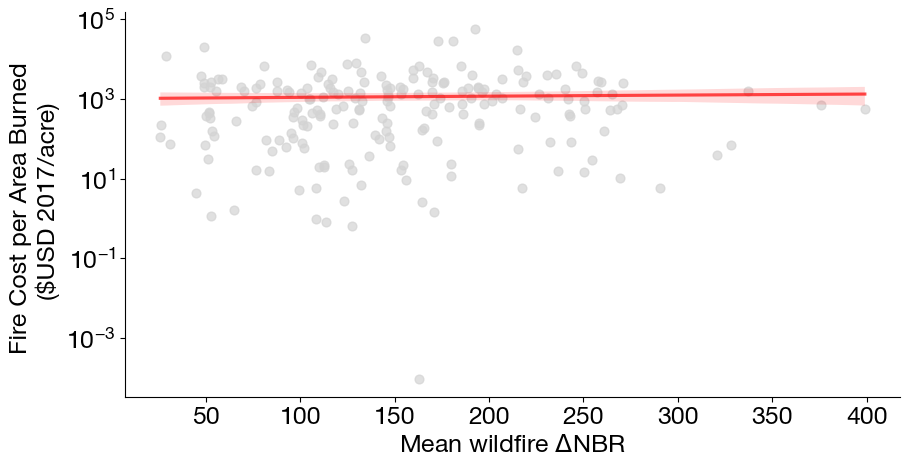

In [20]:
# Calculate cost per area burned
matched = matched.assign(
    **{
        "fire_cost_per_area": (matched.fire_cost_real2017 / matched.area_burned),
    }
)

matched_groupped = matched.groupby("event_id").agg(
    {
        "dnbr_sum": "first",
        "dnbr_mean": "first",
        "fire_cost_per_area": "sum",
        "year": "first",
    }
)

fig, ax = plt.subplots(figsize=(10, 5))
sns.regplot(
    x="dnbr_mean",
    y="fire_cost_per_area",
    robust=True,
    data=matched_groupped,
    ax=ax,
    color="lightgray",
    scatter_kws={"s": 40, "alpha": 0.7},
    line_kws={"color": "red", "alpha": 0.7},
)
sns.despine()

# Change labels
ax.set_xlabel(r"Mean wildfire $\Delta$NBR")
ax.set_ylabel("Fire Cost per Area Burned \n ($USD 2017/acre)")

# Add log-scale to y-axis
ax.set_yscale("log")
# ax.set_xscale("log")

# Save figure
fig.savefig(
    "../figs/costs_suppression_per_area.pdf", dpi=300, bbox_inches="tight"
)

In [21]:
# Run a small FE reg to check this relationship

import pyfixest

pyfixest.feols(
    "fire_cost_per_area ~ dnbr_mean | year", data=matched_groupped
).summary()

###

Estimation:  OLS
Dep. var.: fire_cost_per_area, Fixed effects: year
Inference:  CRV1
Observations:  208

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| dnbr_mean     |      2.369 |        4.878 |     0.486 |      0.638 | -8.501 |  13.239 |
---
RMSE: 5573.101 R2: 0.035 R2 Within: 0.001 
